In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

/var/folders/4_/5vc_xrv55mjf8lnnrnlx1vz40000gn/T/ipykernel_35068/2215073973.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('label').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)
/var/folders/4_/5vc_xrv55mjf8lnnrnlx1vz40000gn/T/ipykernel_35068/2215073973.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('label').apply(lambda

label
cruciate-ligament-minor     355
cruciate-ligament-urgent    355
meniskus-minor              355
meniskus-urgent             355
other-minor                 355
Name: count, dtype: int64


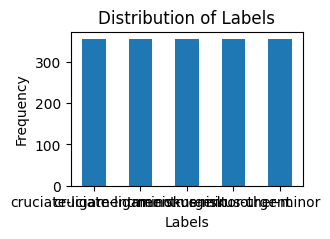

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

min_class_count = df_train['label'].value_counts().min()
df_train = df_train.groupby('label').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

min_class_count = df_valid['label'].value_counts().min()
df_valid = df_valid.groupby('label').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "undersampling"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-07-27 05:56:10.986765: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-27 05:56:10.986801: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-27 05:56:10.986819: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-27 05:56:10.986844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-27 05:56:10.986869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [5]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15


2024-07-27 05:56:11.674800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.2140 - auc: 0.5234 - f1_score: 0.1753 - loss: 1.6080 - val_accuracy: 0.2644 - val_auc: 0.6376 - val_f1_score: 0.2351 - val_loss: 1.5262
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.3481 - auc: 0.6933 - f1_score: 0.3113 - loss: 1.4590 - val_accuracy: 0.3034 - val_auc: 0.6522 - val_f1_score: 0.2983 - val_loss: 1.5055
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.4755 - auc: 0.7759 - f1_score: 0.4565 - loss: 1.2858 - val_accuracy: 0.3271 - val_auc: 0.6540 - val_f1_score: 0.3310 - val_loss: 1.6268
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6033 - auc: 0.8708 - f1_score: 0.6067 - loss: 1.0084 - val_accuracy: 0.3305 - val_auc: 0.6807 - val_f1_score: 0.3433 - val_loss: 1.5916
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.7093 - auc: 0.9231 - f1_score: 0.7177 - loss: 0.7919 - val_accuracy: 0.3610 - val_auc: 0.6780 - val_f1_score: 0.3693 - val_loss: 1.7234
E

In [7]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/undersampling/undersampling.h5
Data saved


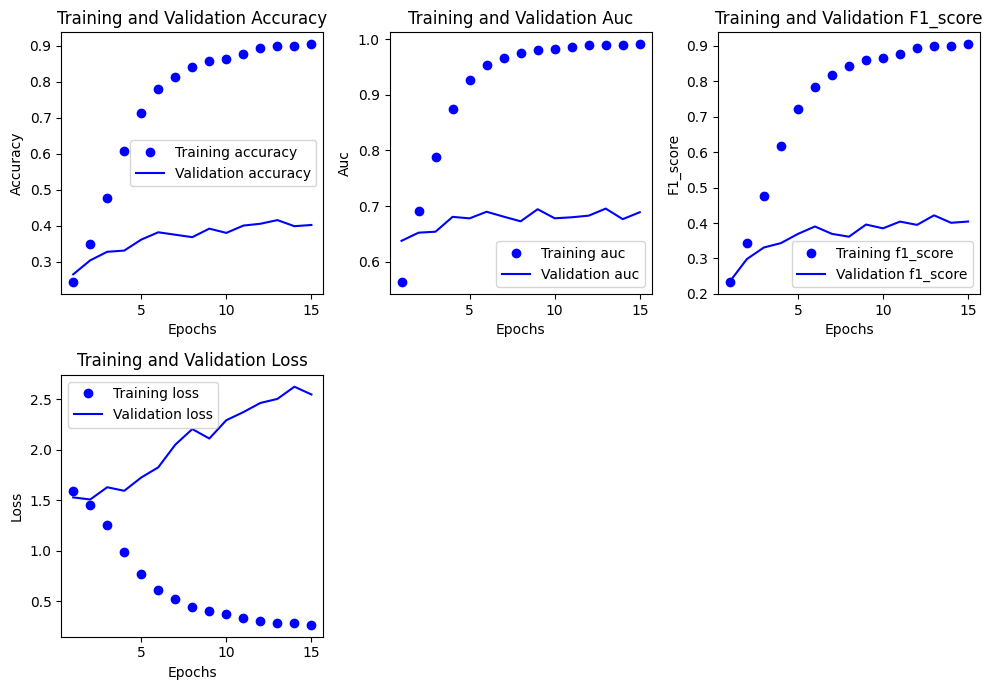

In [8]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


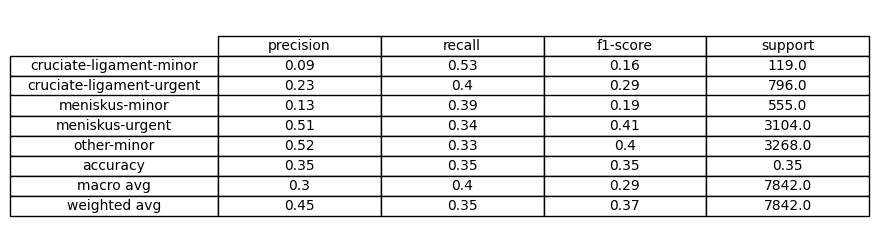

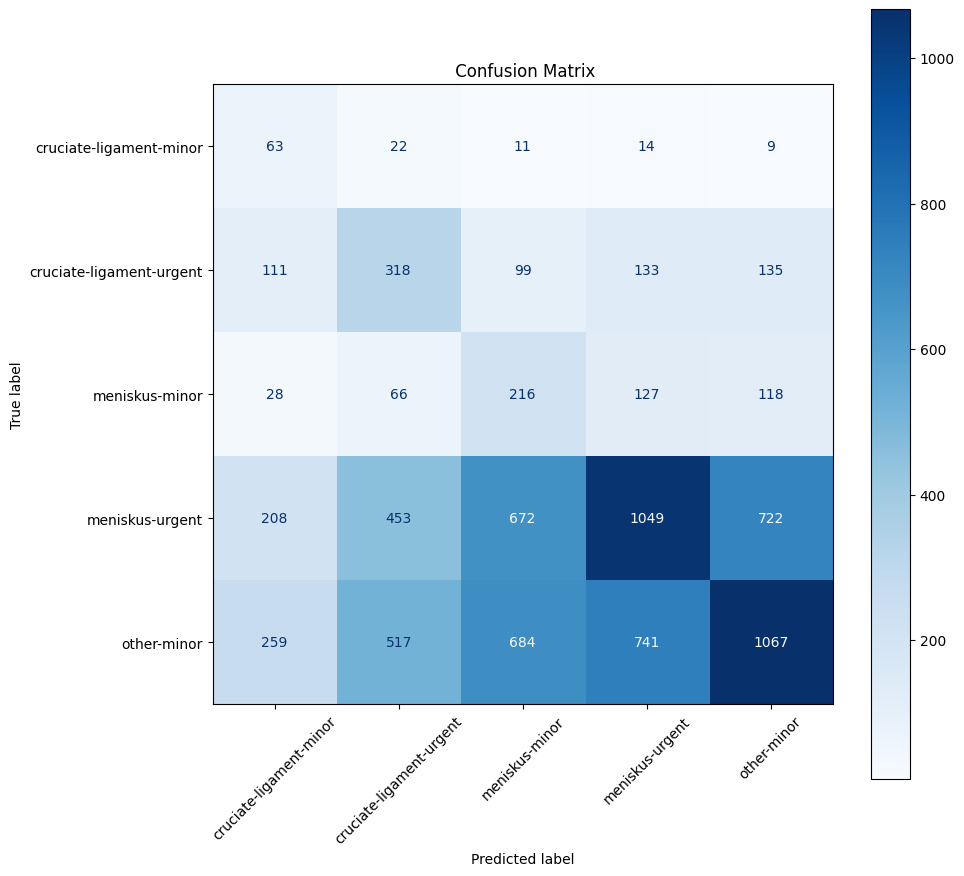

In [9]:
eval(model, test_padded, test_labels, label_encoder)